<a href="https://colab.research.google.com/github/human-centered-ai-lab/app-covid-19-playground/blob/master/covid_19_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Play with Covid 19 visualizations



Hello


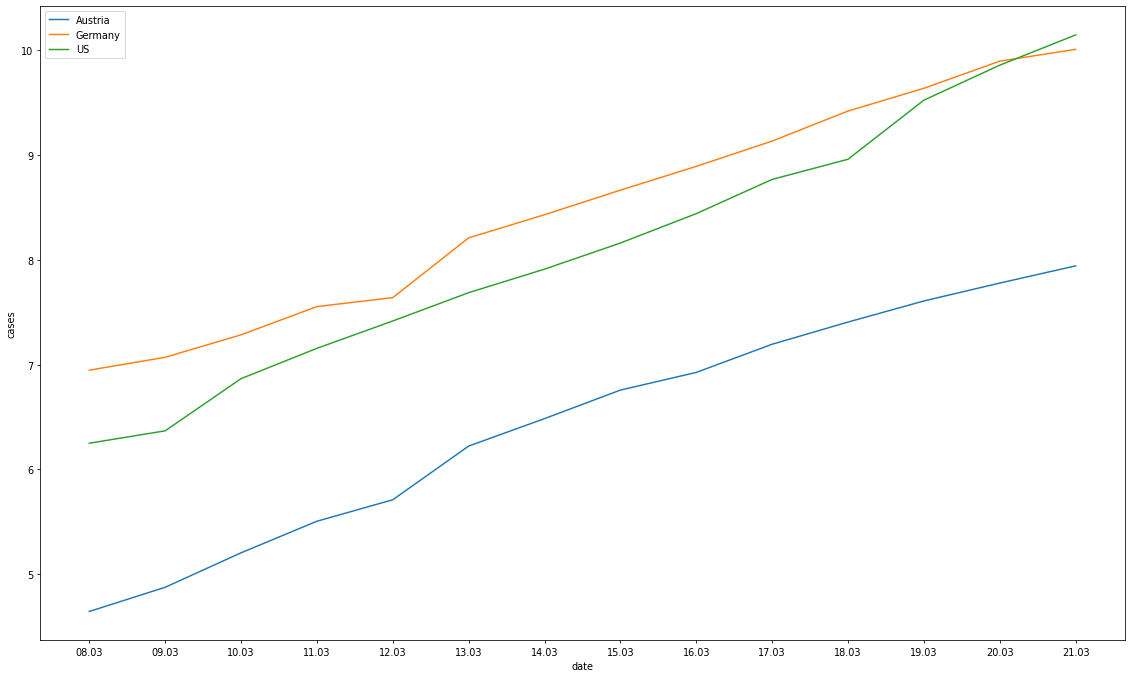

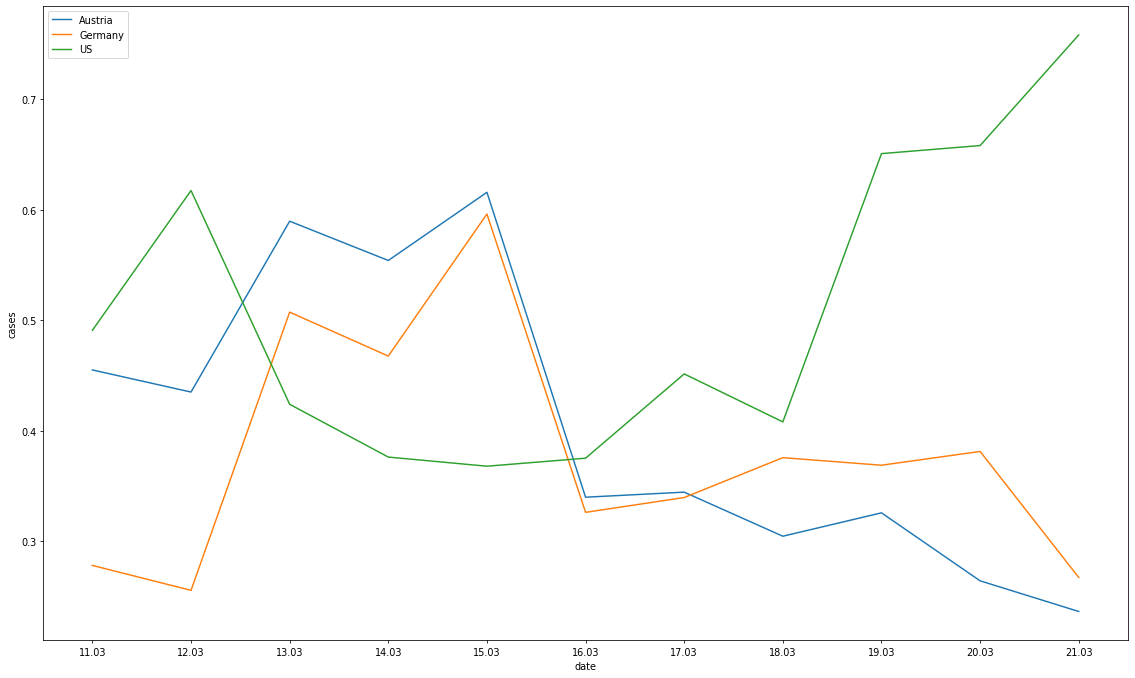

In [4]:
from datetime import timedelta, date
import matplotlib.pyplot as plt
from scipy import signal
import psycopg2 as ps
import seaborn as sns
import pandas as pd
import numpy  as np
import requests
import math
import json

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

width_in_inches = 20
height_in_inches = 12
dots_per_inch = 70
plt.figure( figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

countriesOfInterest = ['Austria', 'Belgium','Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',  'Malta','Netherlands',  'Portugal', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland', 'US', 'United Kingdom']
countriesOfInterest = ['Austria',  'Germany',  'US']



print ("Hello")

r = requests.get(url = "https://pomber.github.io/covid19/timeseries.json") 
data = r.json() 

countries = data.keys()

start_date = date(2020, 3, 8)
end_date   = date(2020, 3, 22)

datesToInspect = []

x_axis_data = [];
for single_date in daterange(start_date, end_date):
    x_axis_data.append(single_date.strftime("%d.%m"))
    datesToInspect.append(single_date.strftime("%Y-%-m-%-d"))

lines = []
labels = []
for c in countriesOfInterest:
  y_axis_data = [];
  for dataindex in datesToInspect:
    datafromonecontry = data[c]
    for daydata in datafromonecontry:
      #print (daydata['date'], dataindex)
      if daydata['date'] == dataindex:
          cc = daydata['confirmed']
          if cc == 0:
            cclog = cc
          else:
            cclog = math.log (cc)
          y_axis_data.append(cclog)
  lines, = plt.plot(x_axis_data,  y_axis_data, label=c)
  labels.append (c)
  plt.legend()

plt.xlabel("date")
plt.ylabel("cases")
plt.show()


plt.figure( figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)
numberOfDays = len(datesToInspect)
offset = 3
for c in countriesOfInterest:
  y_axis_data = [];
  for dataindex in range(numberOfDays-offset):
    datafromonecontry = data[c]
    datastring = datesToInspect[dataindex]
    cc1 = 0
    cc2 = 0
    for daydata in datafromonecontry:
      if daydata['date'] == datastring:
          cc1 = daydata['confirmed']
    datastring = datesToInspect[dataindex+offset]
    for daydata in datafromonecontry:
      if daydata['date'] == datastring:
          cc2 = daydata['confirmed']
    if cc2 == 0:
      v = 0
    else:       
      v = (cc2-cc1) / cc1  / offset
    y_axis_data.append(v)

  y_axis_data_average = moving_average (y_axis_data)

  lines, = plt.plot(x_axis_data[offset:],  y_axis_data, label=c)

  labels.append (c)
  plt.legend()

plt.xlabel("date")
plt.ylabel("cases")


plt.show()
